## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

C:\Users\Davide\Downloads\pydelfi\examples\simulators\jla_supernovae\jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [5]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = priors.Uniform(lower, upper)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [6]:
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [18]:
mu

array([23.00463626, 23.38503031, 22.93014875, 22.22215042, 23.80175361,
       23.60011026, 24.4313949 , 21.94579247, 24.35859377, 22.52540336,
       22.1499578 , 21.97098759, 22.79216405, 22.62426755, 21.34542004,
       23.63850082, 23.27697581, 21.24790337, 25.00000625, 24.5633392 ,
       24.0109443 , 23.51419195, 24.33515517, 23.29290036, 24.13168509,
       23.40291508, 23.47207669, 24.00652061, 21.10024331, 23.88654481,
       24.65486445, 22.04856129, 23.73186866, 24.30152852, 24.52056141,
       24.54561836, 23.22291625, 23.3933786 , 24.58045824, 23.43511813,
       24.36932539, 24.53896761, 24.92883643, 23.40116894, 24.00451157,
       24.30563105, 24.27032683, 22.56399566, 24.65357244, 23.41633575,
       23.97494947, 24.03850046, 24.48040907, 23.6762377 , 22.43015356,
       22.47860343, 22.4746607 , 23.13961211, 23.20314007, 23.99304452,
       24.42383785, 23.59718038, 24.07807846, 22.66060595, 23.48542831,
       23.47653134, 23.75986115, 23.79874393, 24.91701605, 23.56

## Load in the compressed data

In [5]:
JLASimulator.data.shape

(740,)

In [7]:
compressed_data = compressor(JLASimulator.data, compressor_args)

In [7]:
compressed_data.shape

(6,)

In [8]:
mu.shape

(740,)

In [9]:
Cinv.shape

(740, 740)

In [10]:
dmudt.shape

(6, 740)

In [11]:
h

array([0.002  , 0.0075 , 0.1905 , 0.00125, 0.0265 , 0.0005 ])

In [12]:
mu

array([23.00463626, 23.38503031, 22.93014875, 22.22215042, 23.80175361,
       23.60011026, 24.4313949 , 21.94579247, 24.35859377, 22.52540336,
       22.1499578 , 21.97098759, 22.79216405, 22.62426755, 21.34542004,
       23.63850082, 23.27697581, 21.24790337, 25.00000625, 24.5633392 ,
       24.0109443 , 23.51419195, 24.33515517, 23.29290036, 24.13168509,
       23.40291508, 23.47207669, 24.00652061, 21.10024331, 23.88654481,
       24.65486445, 22.04856129, 23.73186866, 24.30152852, 24.52056141,
       24.54561836, 23.22291625, 23.3933786 , 24.58045824, 23.43511813,
       24.36932539, 24.53896761, 24.92883643, 23.40116894, 24.00451157,
       24.30563105, 24.27032683, 22.56399566, 24.65357244, 23.41633575,
       23.97494947, 24.03850046, 24.48040907, 23.6762377 , 22.43015356,
       22.47860343, 22.4746607 , 23.13961211, 23.20314007, 23.99304452,
       24.42383785, 23.59718038, 24.07807846, 22.66060595, 23.48542831,
       23.47653134, 23.75986115, 23.79874393, 24.91701605, 23.56

In [15]:
dmudt[0].shape

(740,)

## Define ensemble of NDEs

In [8]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [9]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:626: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


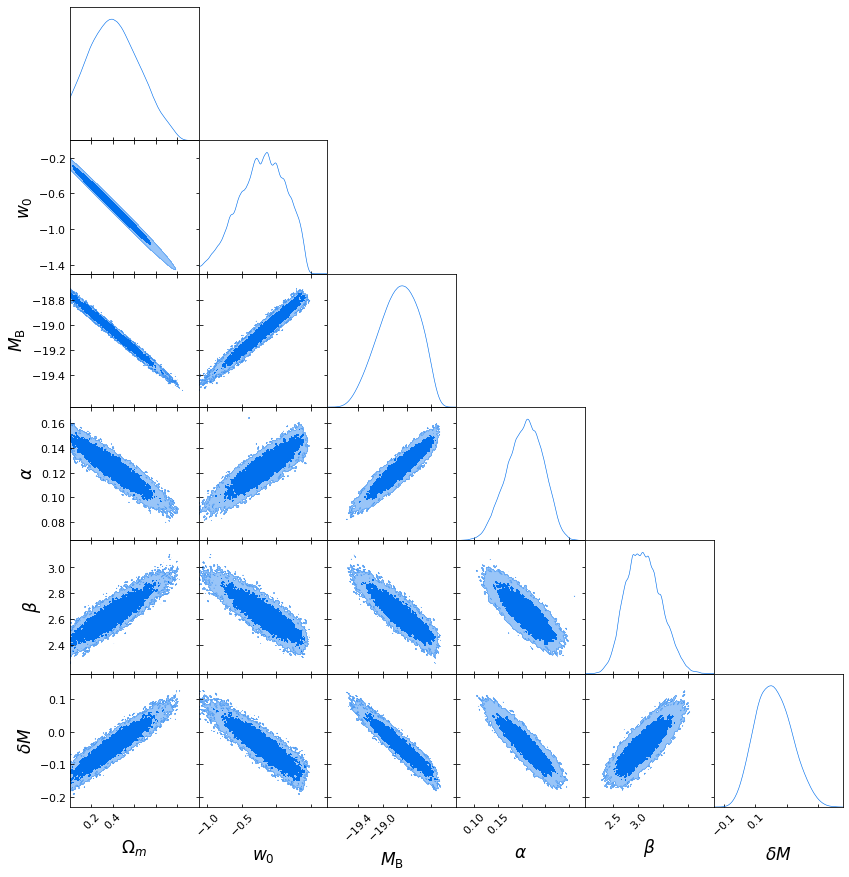

In [10]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood

Population 1/10
Sampling proposal density...
Done.


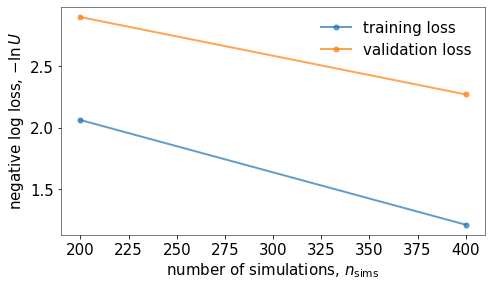

Population 2/10
Sampling proposal density...
Done.


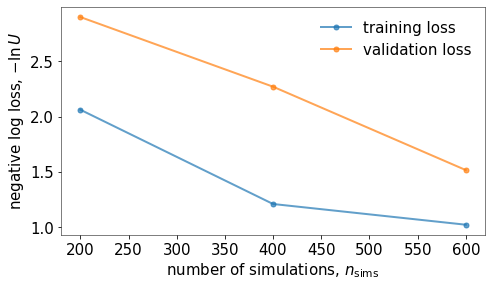

Population 3/10
Sampling proposal density...
Done.


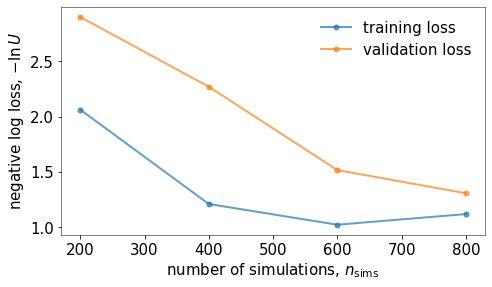

Population 4/10
Sampling proposal density...
Done.


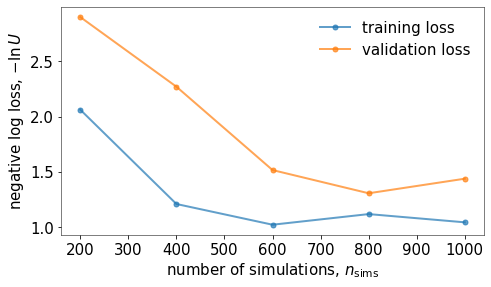

Population 5/10
Sampling proposal density...
Done.


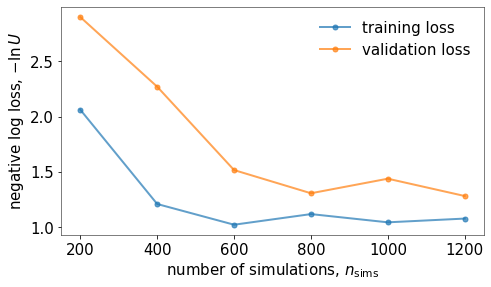

Population 6/10
Sampling proposal density...
Done.


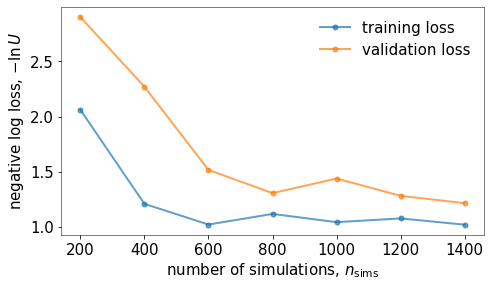

Population 7/10
Sampling proposal density...
Done.


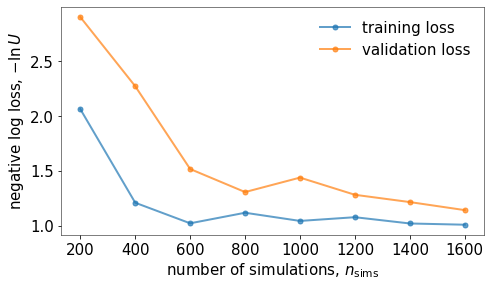

Population 8/10
Sampling proposal density...
Done.


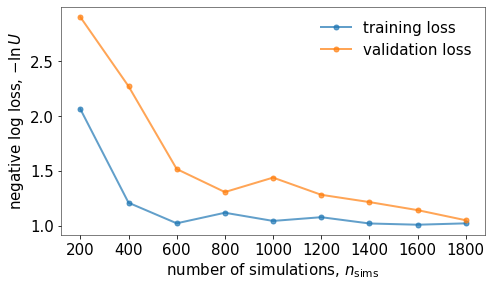

Population 9/10
Sampling proposal density...
Done.


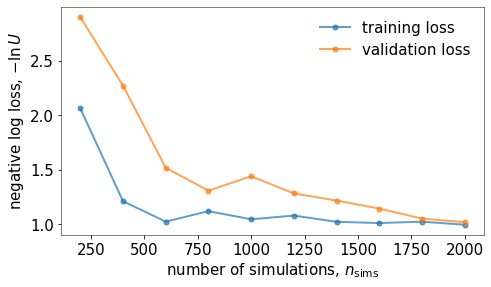

Population 10/10
Sampling proposal density...
Done.


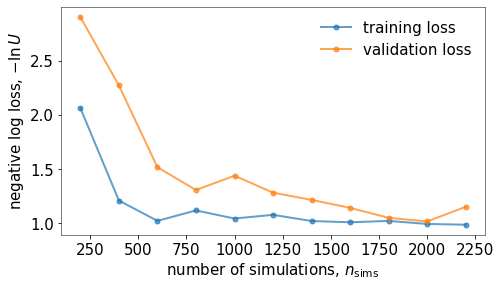

In [11]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [12]:
posterior_samples = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:626: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


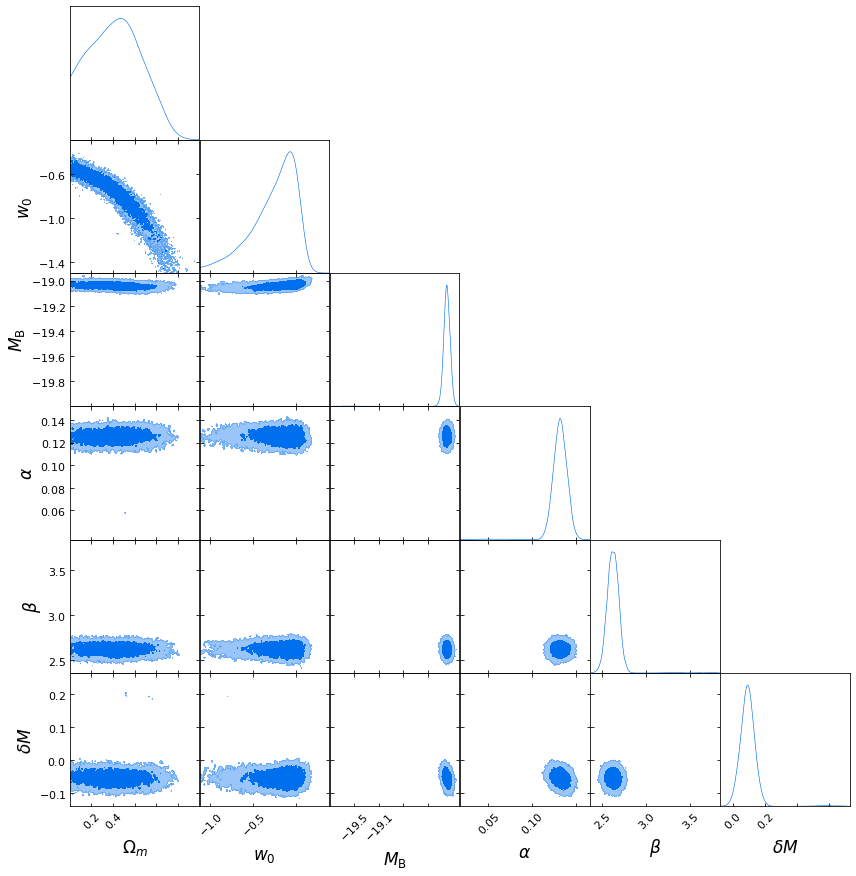

In [13]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])